In [1]:
import warnings
import pandas as pd
from itertools import cycle
import gpflow
import numpy as np
from scipy import linalg
from gpflow.utilities import print_summary, positive
from gpflow.ci_utils import ci_niter
from gpflow.optimizers import NaturalGradient
from gpflow import set_trainable
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from collections import namedtuple
import statsmodels.api as sm
import timeit

sns.set(style="white")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

np.random.seed(123)

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_summary_fmt("notebook")

<ipython-input-1-c790307d65ce>:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
def country_selection(country_name, loc_mobility=None, loc_covid=None, print_summary=True):
    
    avaliable_countries = ["Germany", "Japan", "Australia", "Canada", 
                          "United States", "South Korea", "Italy", "Argentina", 
                          "Turkey", "Thailand", "Colombia", "Mexico",
                          "India", "Kenya", "Bolivia", "Egypt"]
    
    if country_name not in avaliable_countries:
        warnings.warn("The selected country might not have optimal COVID data.")
    else:
        # https://en.wikipedia.org/wiki/List_of_countries_by_inequality-adjusted_HDI
        if country_name in ["Germany", "Japan", "Australia", "Canada"]:
            # Tier 1: 0.800–1.000 (very high)
            tier = 1         
        elif country_name in ["United States", "South Korea", "Italy", "Argentina"]:
            # Tier 2: 0.700–0.799 (high)
            tier = 2
        elif country_name in ["Turkey", "Thailand", "Algeria", "Mexico"]:
            # Tier 3: 0.550–0.699 (medium)
            tier = 3
        else:
            # Tier 4: 0.350–0.549 (low)
            tier = 4
            
    if loc_mobility==None:
        loc_mobility="./Data/Google/Global_Mobility_Report.csv"
        
    mobility_data = pd.read_csv(loc_mobility, 
                                encoding="ISO-8859-1", 
                                parse_dates=["date"],
                                dayfirst=True, low_memory=False)
    
    mobility_data = mobility_data[
        (mobility_data["country_region"]==country_name) & 
        (mobility_data["sub_region_1"].isnull()) & 
        (mobility_data["metro_area"].isnull())]
    mobility_data = mobility_data.iloc[:,7:].reset_index(drop=True) # keep only relevant columns
    mobility_data.iloc[:,1:] = mobility_data.iloc[:,1:].apply(lambda x: x/100 + 1)
    
    mobility_data = pd.DataFrame({
        "date": mobility_data["date"],
        "HOME": mobility_data['residential_percent_change_from_baseline'],
        "WORK": mobility_data['workplaces_percent_change_from_baseline'],
        "RECREATIONAL": mobility_data['retail_and_recreation_percent_change_from_baseline'],
        "OTHER": mobility_data.iloc[:,2:5].mean(axis=1)
    })
    mobility_data.reset_index(drop=True, inplace=True)
    
    if loc_covid==None:
        loc_covid="./Data/Microsoft/COVID_CASES.csv"
     # COVID Cases from Microsoft, includes Recovered and Infected
    ms_covid = pd.read_csv(loc_covid, 
                           encoding="ISO-8859-1",
                           parse_dates=["Updated"],
                           dayfirst=False, low_memory=False)
    
    ms_covid = ms_covid[(ms_covid["Country_Region"]==country_name) & (ms_covid["AdminRegion1"].isnull())]
    ms_covid = ms_covid.loc[:,["Updated", "Confirmed", "ConfirmedChange", "Deaths", "Recovered"]]   
    
    # Create the 3 categories S, I, R for US data (UK does not include R)
    ms_covid = ms_covid.fillna(method='ffill').fillna(0)

    # DIFF: Instead of smoothing the I, Daily cases and S, ammend the problematic R value @ 2020-07-18
    # To match the next 2020-07-19
    if country_name=="United States":
        ms_covid.iloc[178, 4] = 1117084.0
        
    # Read the countries population from World Bank Database 2019
    pop_dt = pd.read_excel(
        "./Data/Population/Data_Extract_From_World_Development_Indicators.xls")
    

    population_size = pop_dt.loc[pop_dt.CountryName==country_name, "Total"].values[0]
    
    ms_covid["I"] = ms_covid["Confirmed"] - ms_covid["Deaths"] - ms_covid["Recovered"]
    ms_covid["S"] = population_size - ms_covid["I"]
    ms_covid["index"] = ms_covid["Updated"].dt.dayofyear

    # DIFF: Create a time variable
    # If we have a weekend then assign 0 or weekday 1
    ms_covid["WEEKDAY"] = (ms_covid["Updated"].dt.dayofweek < 5).astype(int)
    
    ms_covid["ConfirmedChange"] = np.log(ms_covid["ConfirmedChange"].rolling(7).median()+1)
    ms_covid["I"] = ms_covid["I"].rolling(7).median()
    ms_covid["S"] = ms_covid["S"].rolling(7).median()

    ms_covid.dropna(inplace=True)
    ms_covid.reset_index(drop=True, inplace=True)
    
    final_data = ms_covid.set_index("Updated").merge(
    mobility_data.set_index("date"), how='left', left_index=True, right_index=True).reset_index()
    final_data.dropna(inplace=True)
    final_data.reset_index(drop=True, inplace=True)
    final_data.columns.values[0] = "Updated"
    
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 4))
    fig.suptitle("{0} is a Tier {1} country in IHDI".format(country_name, int(tier)), fontsize=16)
    final_data.set_index("Updated")[["ConfirmedChange"]].plot(ax=axs[0, 0])
    final_data.set_index("Updated")[["I"]].plot(ax=axs[0, 1])
    final_data.set_index("Updated")[["S"]].plot(ax=axs[0, 2])
    final_data.set_index("Updated")[["HOME"]].plot(ax=axs[1, 0])
    final_data.set_index("Updated")[["WORK"]].plot(ax=axs[1, 1])
    final_data.set_index("Updated")[["OTHER"]].plot(ax=axs[1, 2])
    
    if print_summary:
        print(round(final_data.describe(), 3))
    
    return(final_data)

In [3]:
def kernel_analysis(model, k, X_kernel):
      
    # Extract the eigenvalues
    eigv = linalg.eigvals(k(X_kernel)) # pre-opt
    eigv_opt = linalg.eigvals(model._model.kernel(X_kernel)) # after-opt
    
    # Generate the plots
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
    fig.suptitle("Before Optimization", fontsize=16)
    ax[0].plot(np.mean(np.random.multivariate_normal(np.zeros(X_kernel.shape[0]), k(X_kernel), 100).T, axis=1))
    ax[1].imshow(k(X_kernel))
    ax[2].bar(np.arange(X_kernel.shape[0]), eigv)

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
    fig.suptitle("After Optimization", fontsize=16)
    ax[0].plot(np.mean(np.random.multivariate_normal(np.zeros(X_kernel.shape[0]), model._model.kernel(X_kernel), 100).T, axis=1))
    ax[1].imshow(model._model.kernel(X_kernel))
    ax[2].bar(np.arange(X_kernel.shape[0]), eigv_opt)

In [4]:
def GP_country_predict(model):
    
    avaliable_countries = ["Germany", "Japan", "Australia", "Canada",
                       "United States", "South Korea", "Italy", "Argentina",
                       "Turkey", "Thailand", "Colombia", "Mexico",
                       "India", "Kenya", "Bolivia", "Egypt"]
    
    for c_index, country in enumerate(avaliable_countries):
        
        # Source Data
        country_dt = country_selection(country, print_summary=False)
        t = country_dt[["Updated"]].to_numpy()
        y = country_dt[["ConfirmedChange"]].to_numpy()
        X = np.hstack([
            country_dt[["index"]].to_numpy(),
            country_dt[["S"]].to_numpy(),
            country_dt[["I"]].to_numpy(),
            country_dt[["HOME"]].to_numpy(),
            country_dt[["WORK"]].to_numpy(),
            country_dt[["RECREATIONAL"]].to_numpy(),
            country_dt[["WEEKDAY"]].to_numpy(),
        ])

        # Normalise the Data
        X_scaler = preprocessing.StandardScaler().fit(X)
        X_norm = X_scaler.transform(X)

        y_scaler = preprocessing.StandardScaler().fit(y)
        y_norm = y_scaler.transform(y)
        y_std = abs(np.std(y))
        
        # Make model predictions
        mean, var = model.predict(X_norm)
        Y_pred = y_scaler.inverse_transform(mean)
        
        # Cases difference (error)
        error = abs(round(np.mean(np.exp(y) - np.exp(Y_pred)), 0))
        error_log = abs(round(np.mean(y - Y_pred), 3))
        
        # Plot the results
        fig, ax = plt.subplots(1, figsize=(20, 4))
        fig.suptitle("{0}: The average cases error is, {1} or {2} daily cases.".format(country, error_log, int(error)), fontsize=16)
        ax.plot(t, y, "o", c="C2", alpha=0.7, label="Actual Daily COVID cases")
        ax.plot(t, Y_pred, "-", c="C0", label="Predicted Daily COVID cases")
        
        lo = (Y_pred - 2 * tf.sqrt(var)*y_std).numpy()
        hi = (Y_pred + 2 * tf.sqrt(var)*y_std).numpy()
        ax.fill_between(t.flatten(), lo.flatten(), hi.flatten(), alpha=0.3)
        ax.legend()
        
        # Plot the covariance matrices
        k = gpflow.kernels.SquaredExponential() * gpflow.kernels.Linear() * gpflow.kernels.RationalQuadratic()
        kernel_analysis(model, k, X_norm)
        



In [5]:
country_name = 'United States'

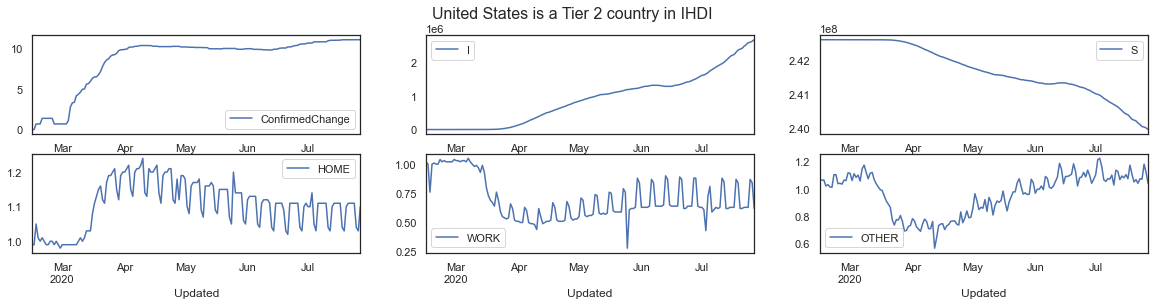

In [6]:
final_data = country_selection(country_name, print_summary=False)

In [7]:
final_data.head()

,Updated,Confirmed,ConfirmedChange,Deaths,Recovered,I,S,index,WEEKDAY,HOME,WORK,RECREATIONAL,OTHER
0,2020-02-15,15,0.000000,1.0,3.0,9.0,242620791.0,46,0,0.99,1.02,1.06,1.066667
1,2020-02-16,15,0.000000,1.0,3.0,10.0,242620790.0,47,0,0.99,1.00,1.07,1.063333
2,2020-02-17,18,0.693147,2.0,3.0,11.0,242620789.0,48,1,1.05,0.76,1.06,1.063333
3,2020-02-18,21,0.693147,2.0,3.0,11.0,242620789.0,49,1,1.01,1.00,1.00,1.020000
4,2020-02-19,24,0.693147,2.0,3.0,11.0,242620789.0,50,1,1.00,1.01,1.02,1.030000


In [8]:
from experiment import run_experiment, Report

In [9]:
def train_test_split_func(t, X, y):
    t_train, t_test = t[:-21,:], t[-21:,:]
    X_train, X_test = X[:-21,:], X[-21:,:]
    y_train, y_test = y[:-21,:], y[-21:,:]
    
    return t_train, t_test, X_train, X_test, y_train, y_test

In [10]:
print("Date range, min {0} and max {1}.".format(min(final_data.Updated), max(final_data.Updated)))

Date range, min 2020-02-15 00:00:00 and max 2020-07-27 00:00:00.


### **$\lambda (t) = f(t, S(t), I(t), Home(t), Work(t), Recreational(t), Weekday(t))$** - Gaussian - SE\*L\*RQ

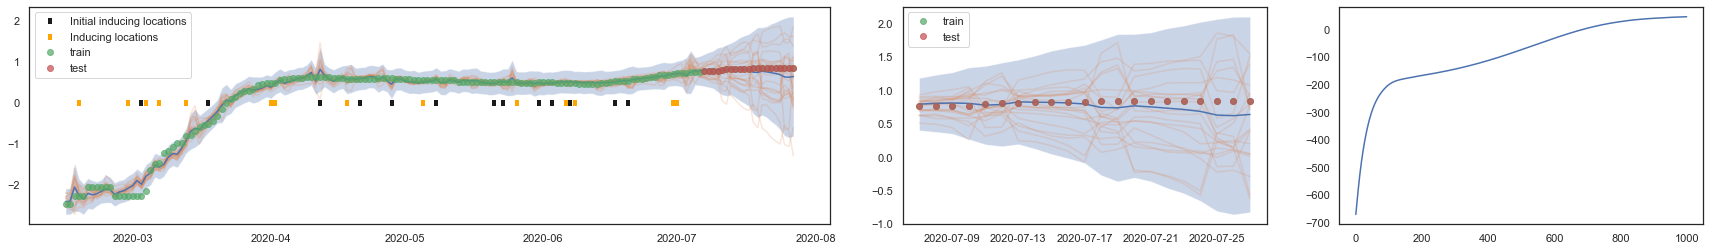

In [11]:
t = final_data[["Updated"]].to_numpy()
y = final_data[["ConfirmedChange"]].to_numpy()
X = np.hstack([
    final_data[["index"]].to_numpy(),
    final_data[["S"]].to_numpy(),
    final_data[["I"]].to_numpy(),
    final_data[["HOME"]].to_numpy(),
    final_data[["WORK"]].to_numpy(),
    final_data[["RECREATIONAL"]].to_numpy(),
    final_data[["WEEKDAY"]].to_numpy(),
])

model_params = {
    'kernel': (
        gpflow.kernels.SquaredExponential(lengthscales=np.ones(X.shape[1])) *
        gpflow.kernels.Linear() * 
        gpflow.kernels.RationalQuadratic(lengthscales=np.ones(X.shape[1]))
    ),
    'n_inducing': (15)
}

res, model = run_experiment('$f(t, S(t), I(t), Home(t), Work(t), Recreational(t), Weekday(t))$', t, X, y, 
                            model_params=model_params, 
                            train_test_split_func=train_test_split_func, 
                            plot=True)


In [12]:
model._model.kernel

name,class,transform,prior,trainable,shape,dtype,value
Product.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.2934118912044815
Product.kernels[0].lengthscales,Parameter,Softplus,,True,"(7,)",float64,"[0.8861872, 3.79476766, 3.45017933..."
Product.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.2934118912044816
Product.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.2934118912044816
Product.kernels[2].lengthscales,Parameter,Softplus,,True,"(7,)",float64,"[2.81676751, 4.56644728, 4.3885228..."
Product.kernels[2].alpha,Parameter,Softplus,,True,(),float64,0.7250975661576036


In [ ]:
# $f(t, S(t), I(t), Home(t), Work(t), Recreational(t), Weekday(t))$

In [13]:
model._model.kernel.kernels[0].lengthscales

<Parameter: dtype=float64, shape=[7], fn="softplus", numpy=
array([0.8861872 , 3.79476766, 3.45017933, 5.00924909, 4.23878056,
       3.79265511, 4.88545972])>

In [14]:
model._model.kernel.kernels[2].lengthscales

<Parameter: dtype=float64, shape=[7], fn="softplus", numpy=
array([2.81676751, 4.56644728, 4.3885228 , 5.42176027, 4.93785652,
       4.19657269, 6.04008471])>

In [15]:
res.to_pandas()

,Summary
Model,"$f(t, S(t), I(t), Home(t), Work(t), Recreational(t), Weekday(t))$"
Likelihood,Gaussian
Kernel,Product
ELBO,46.18
Training-set dates,2020-02-15 to 2020-07-06
Test-set dates,2020-07-07 to 2020-07-27
train_size,143
test_size,21
Number of inducing points,15
run_time,141.369


/Users/georgiospapadopoulos/opt/anaconda3/envs/hyperion/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/georgiospapadopoulos/opt/anaconda3/envs/hyperion/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/georgiospapadopoulos/opt/anaconda3/envs/hyperion/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/georgiospapadopoulos/opt/anaconda3/envs/hyperion/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/georgiospapadopoulos/opt/anaconda3/envs/hyperion/

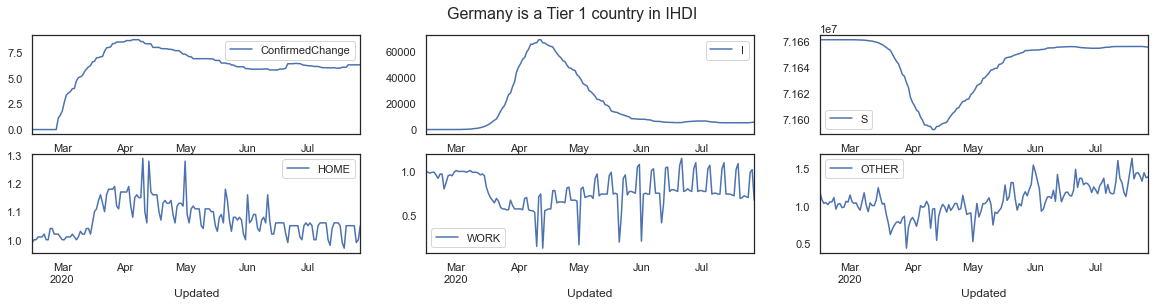

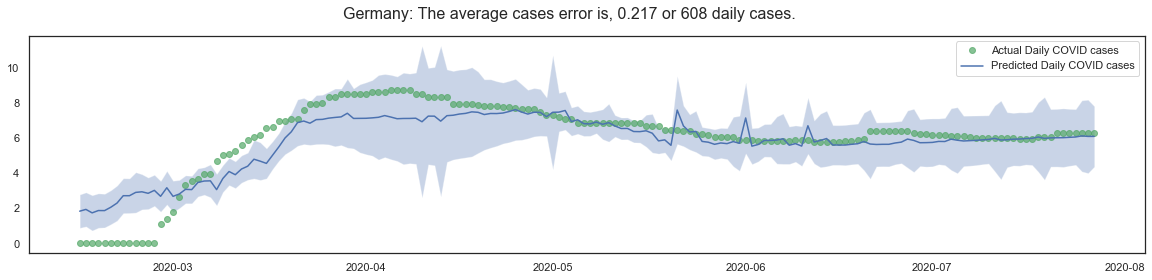

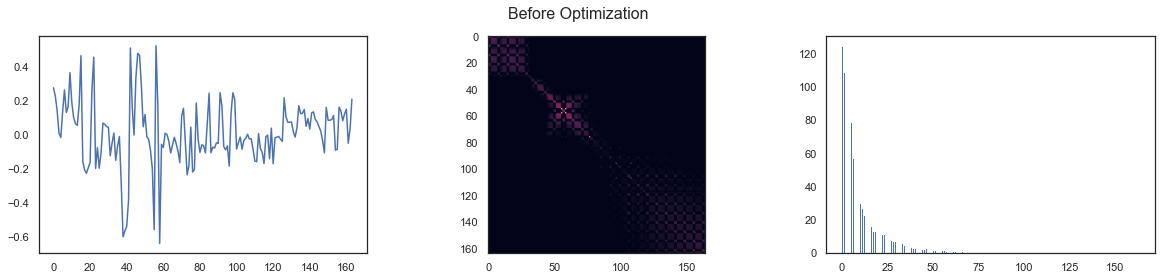

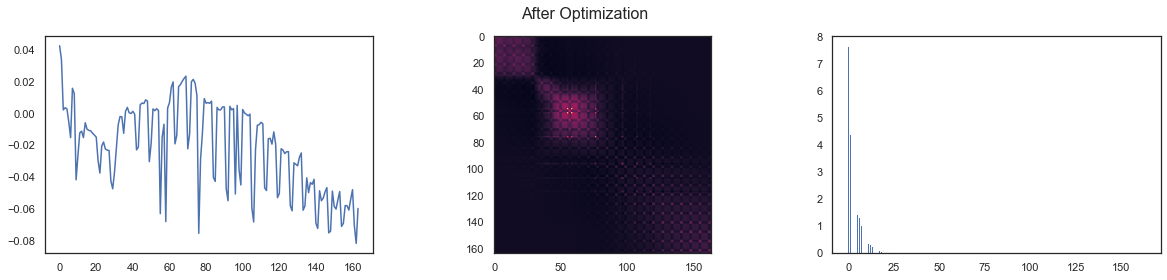

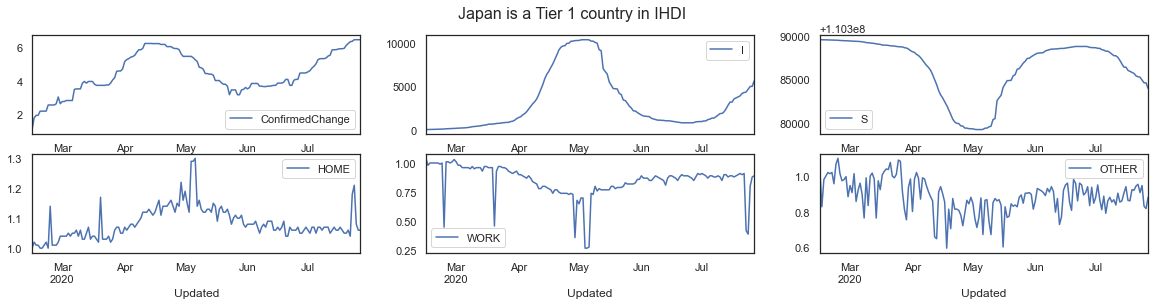

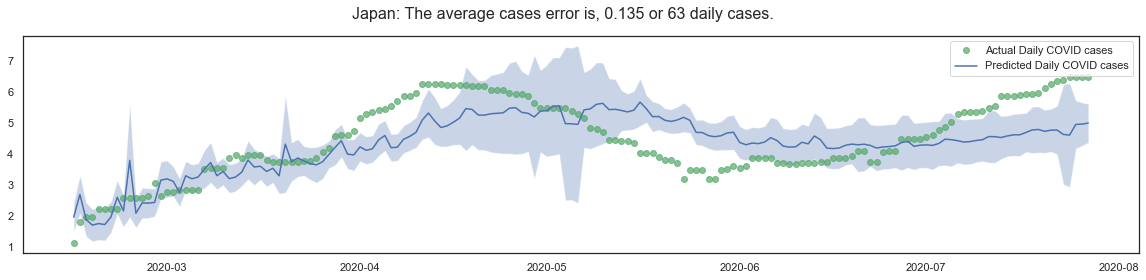

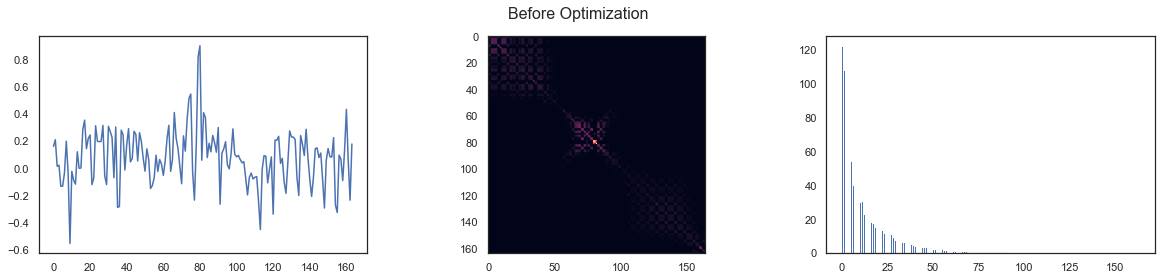

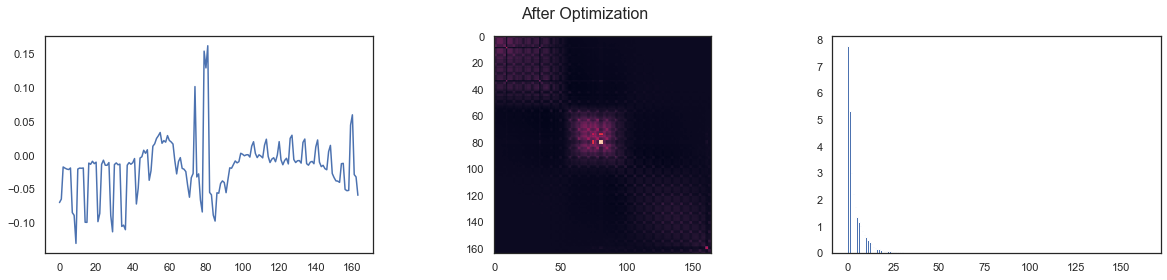

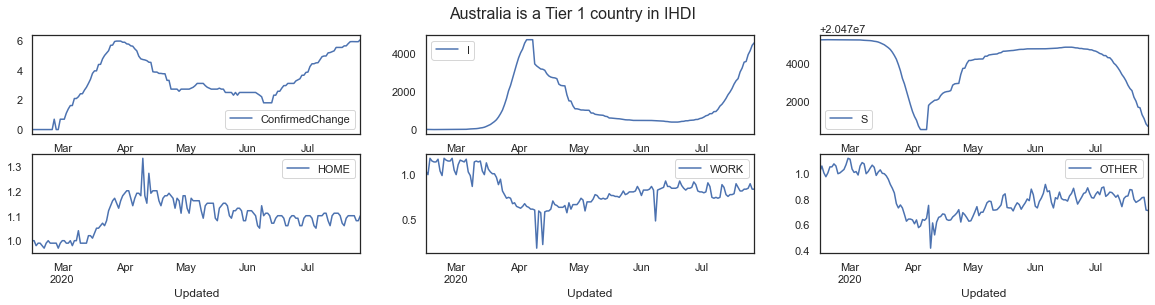

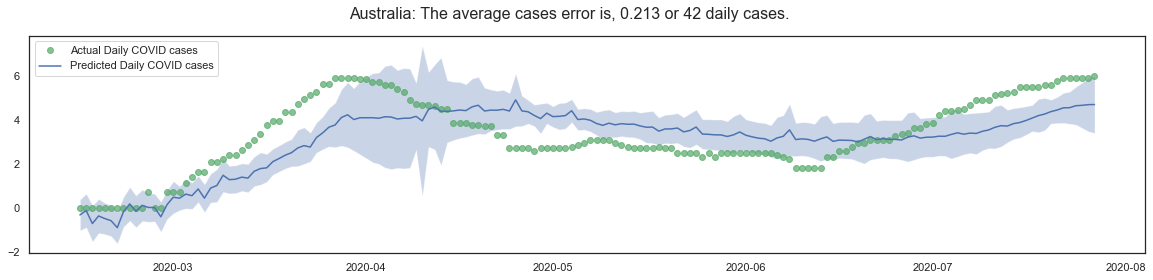

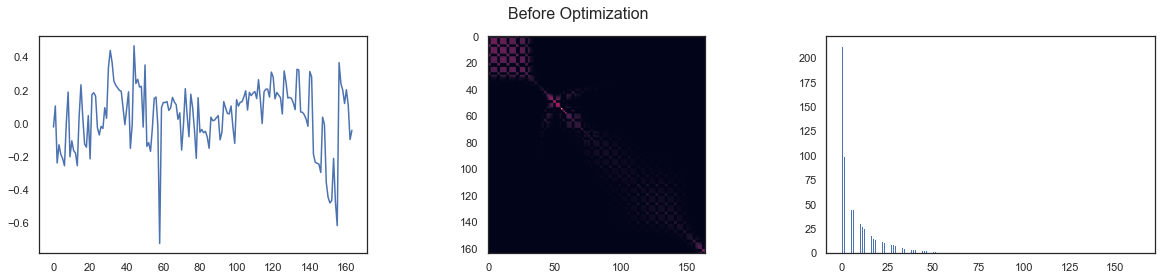

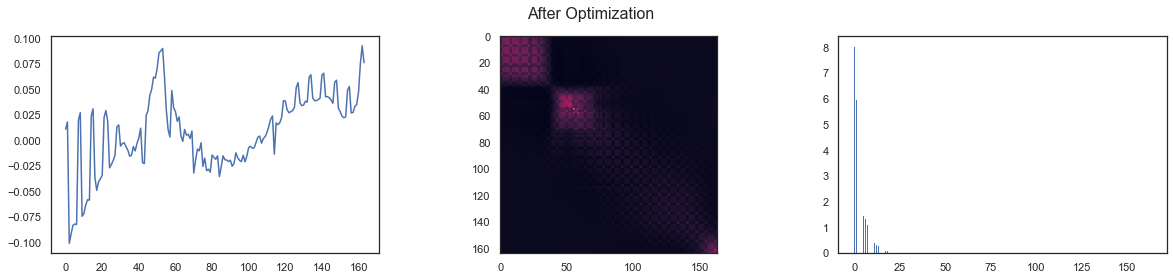

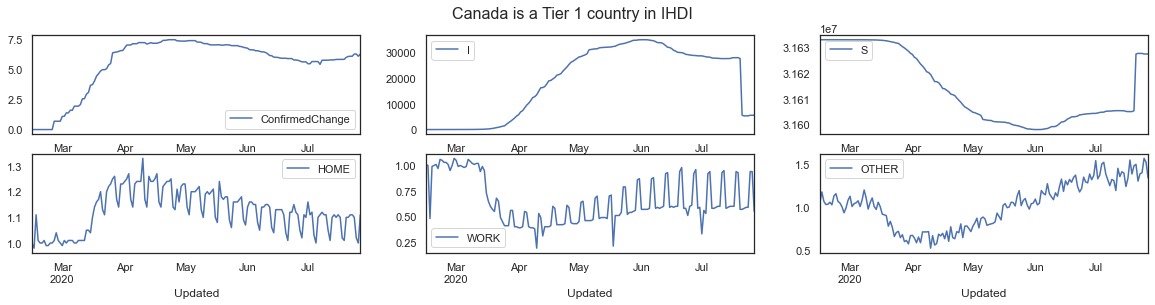

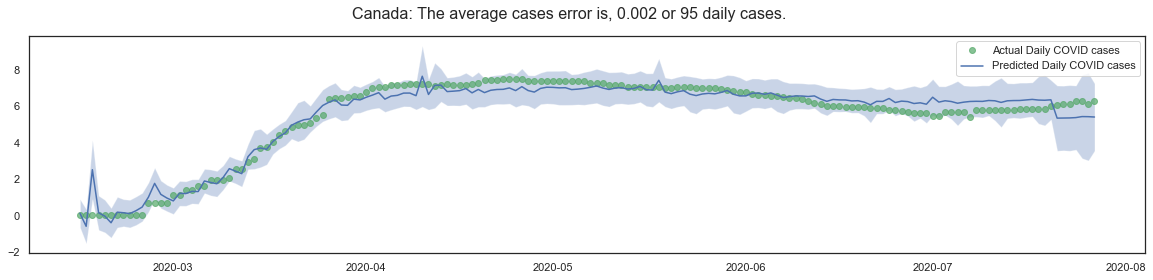

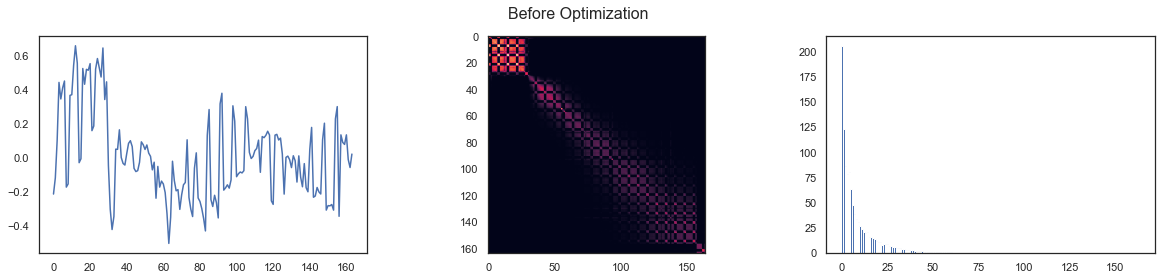

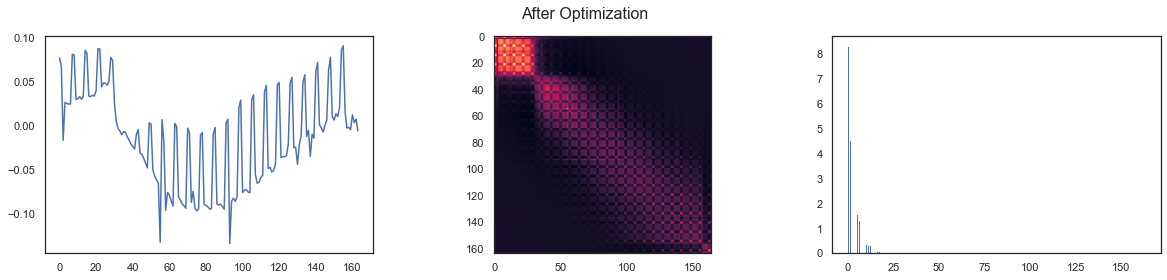

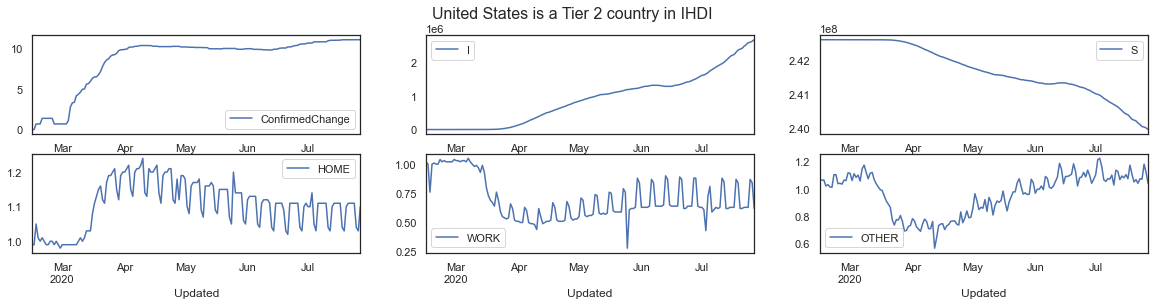

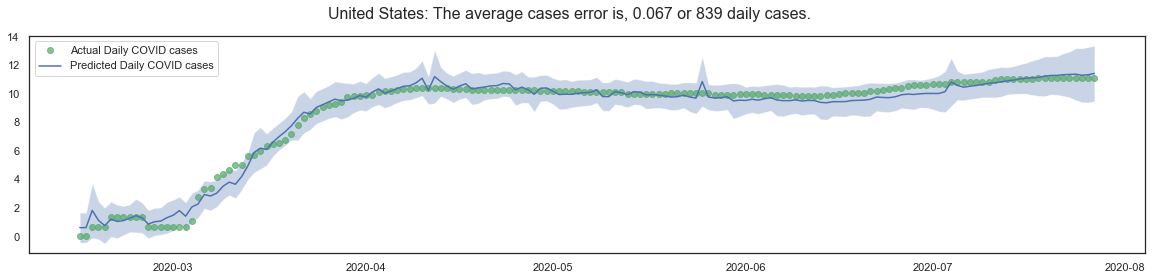

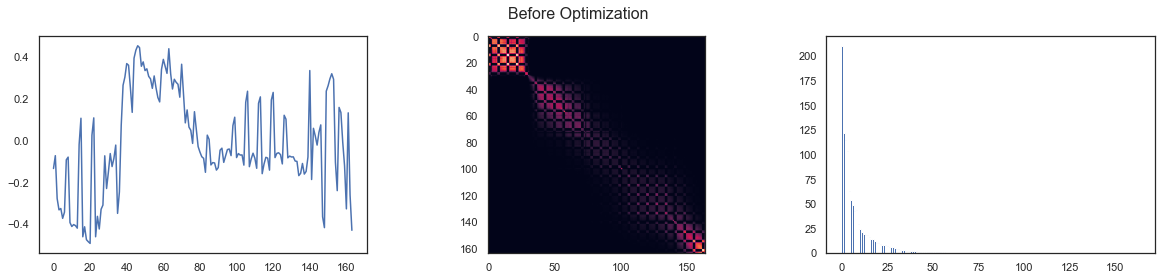

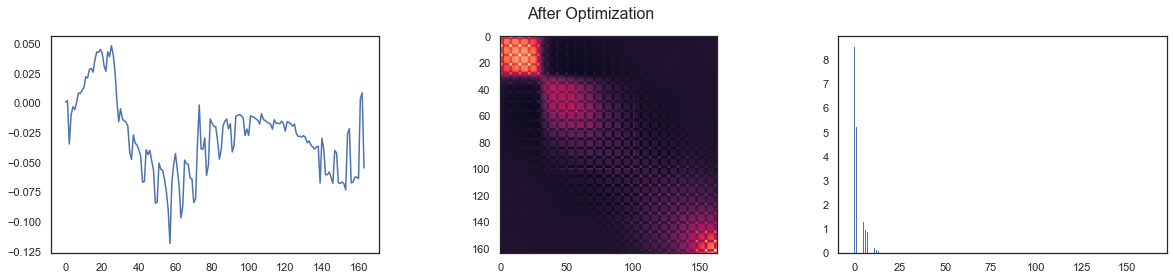

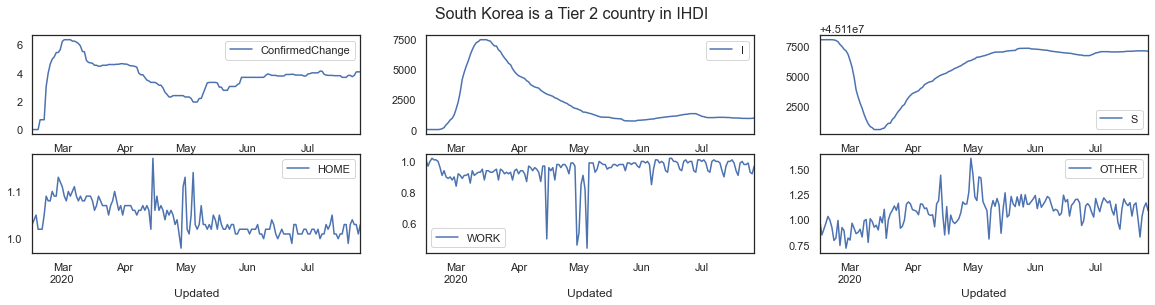

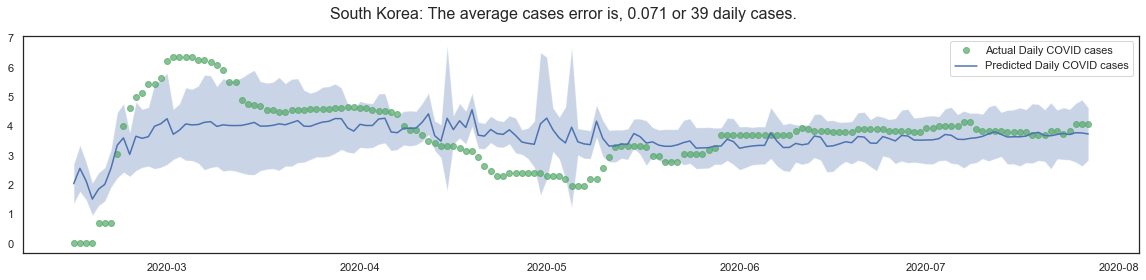

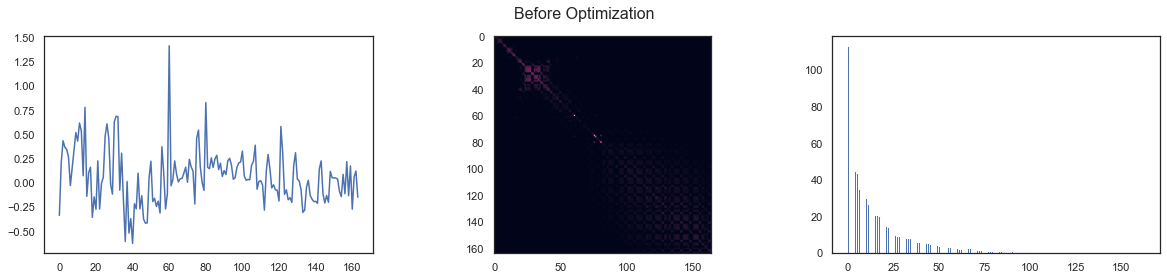

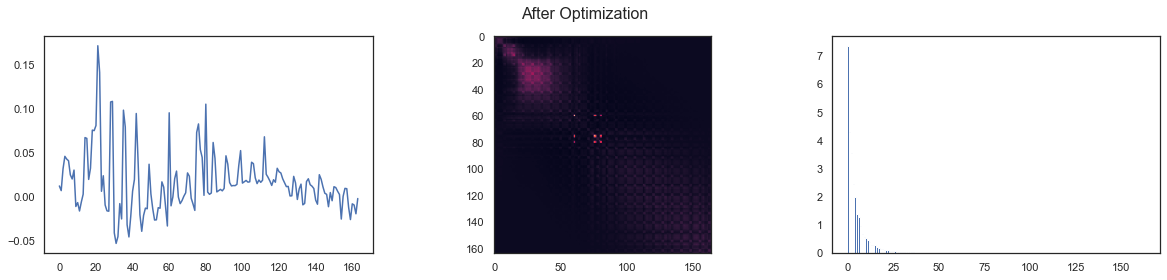

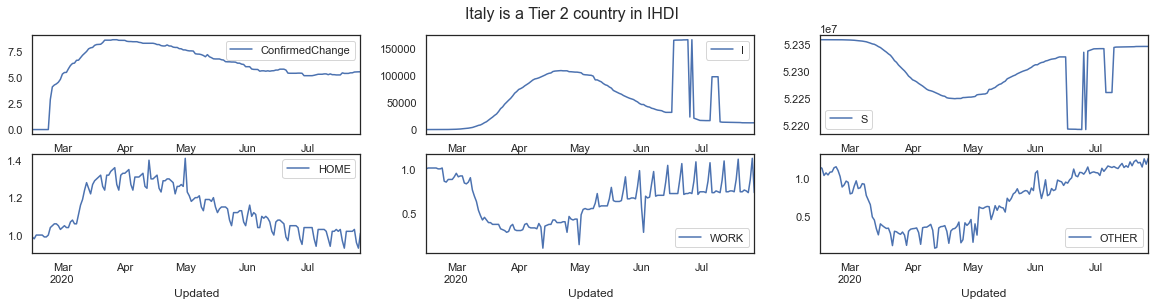

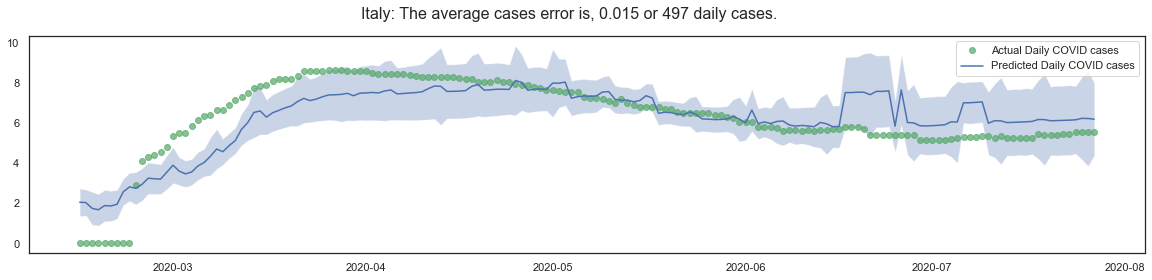

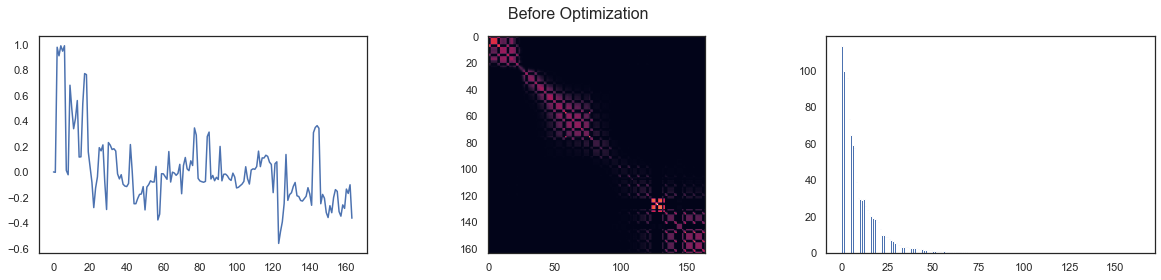

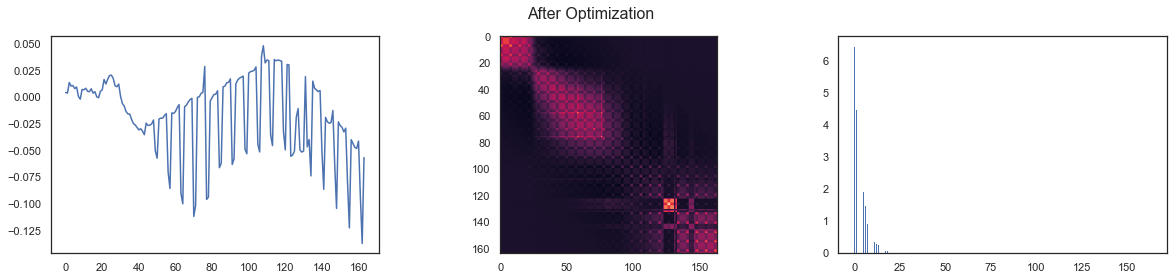

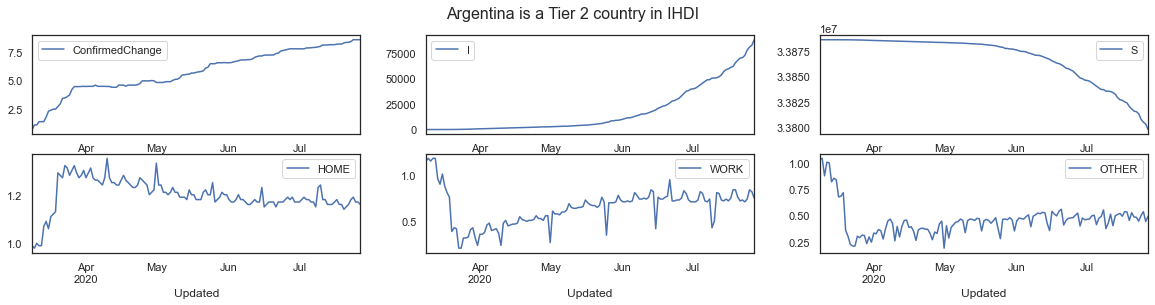

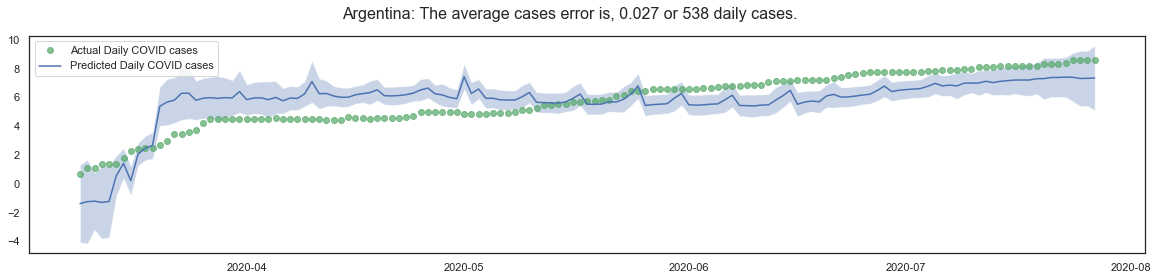

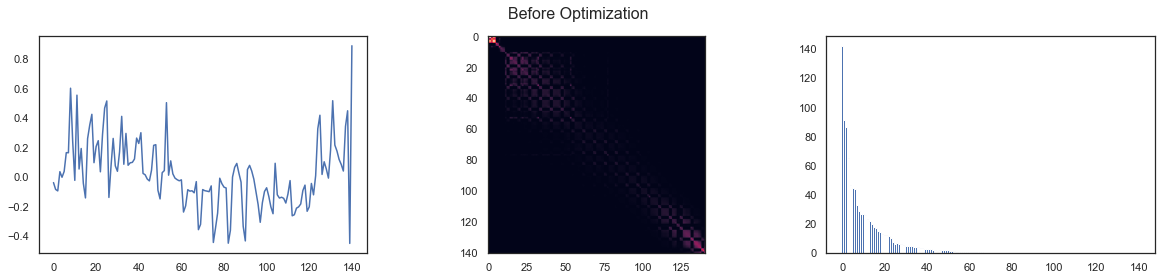

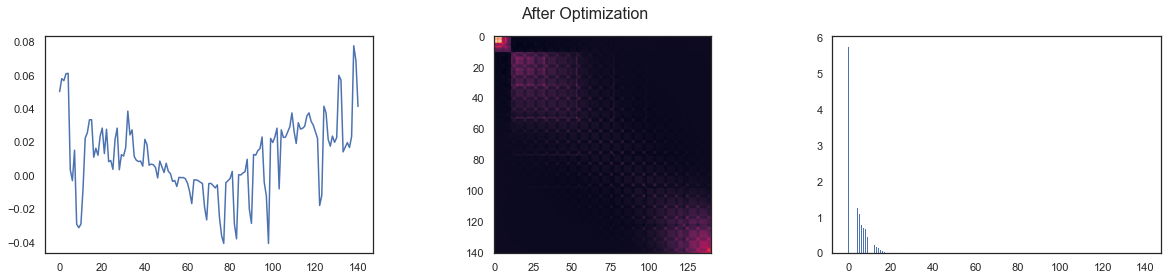

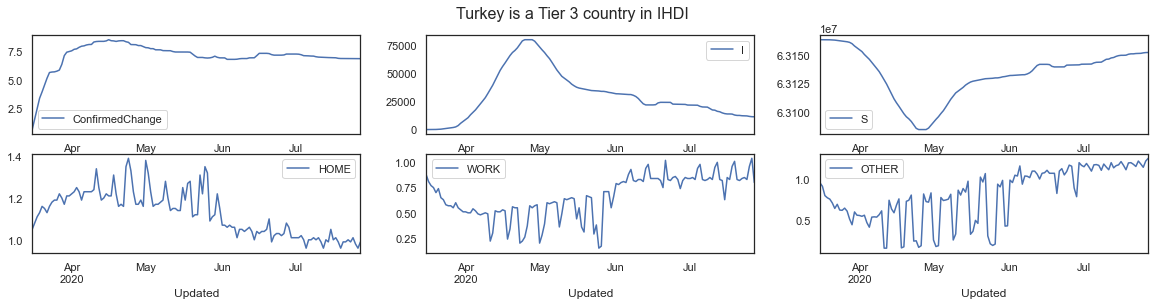

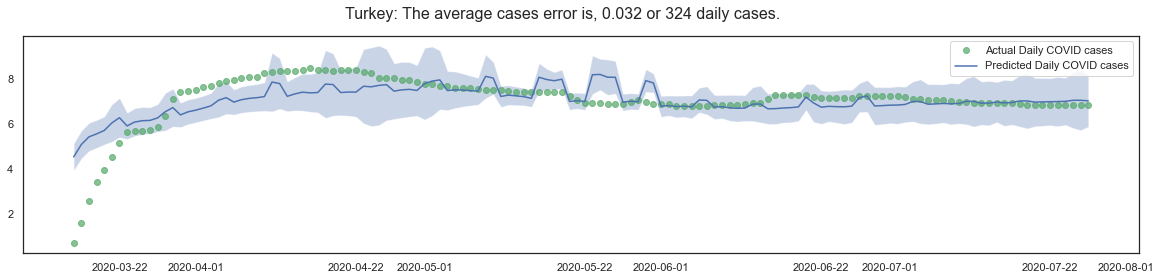

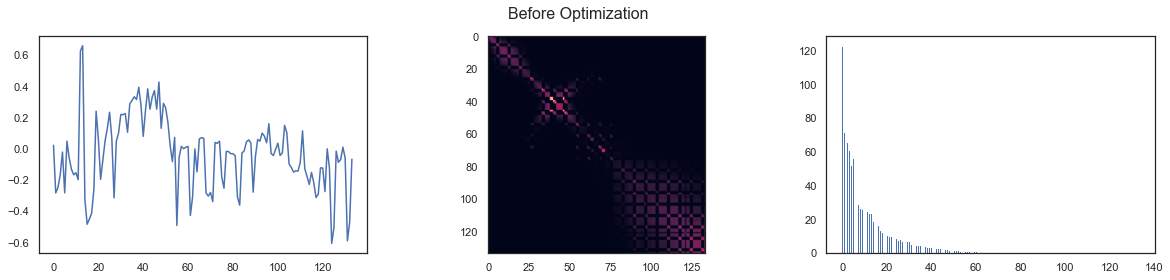

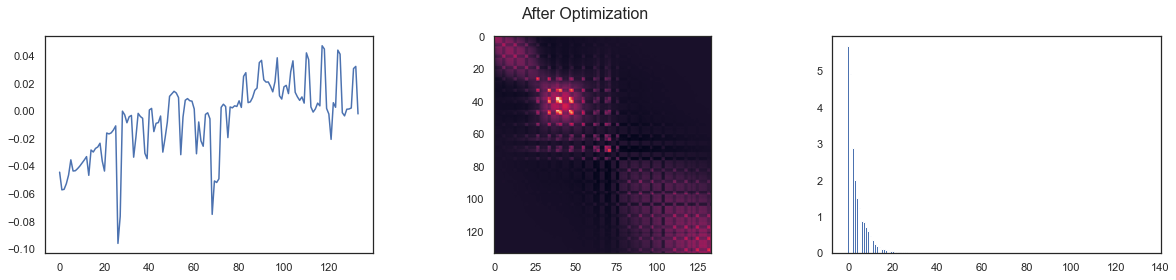

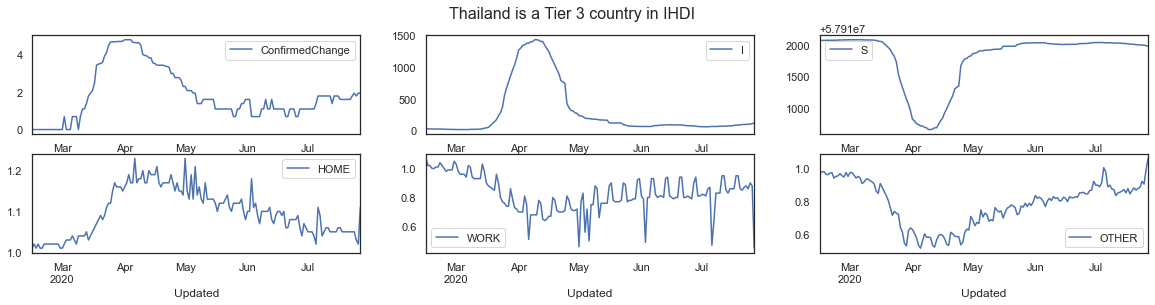

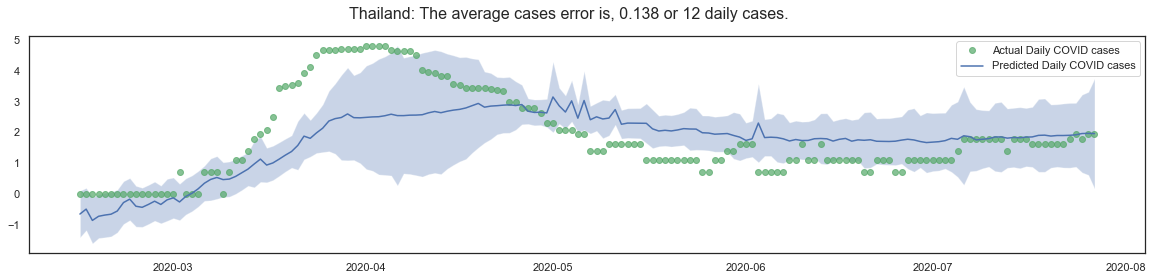

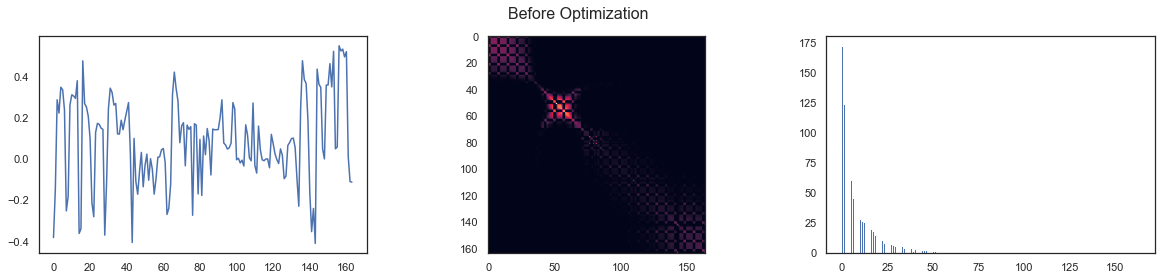

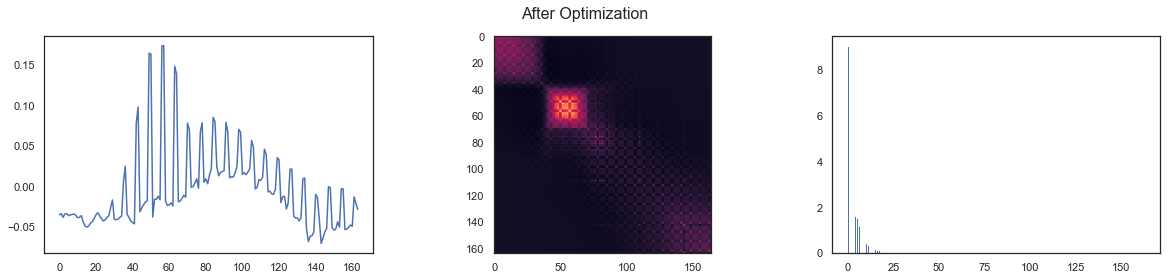

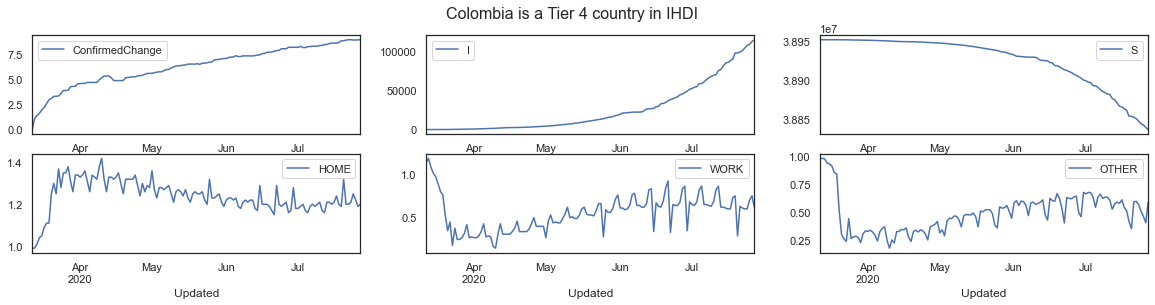

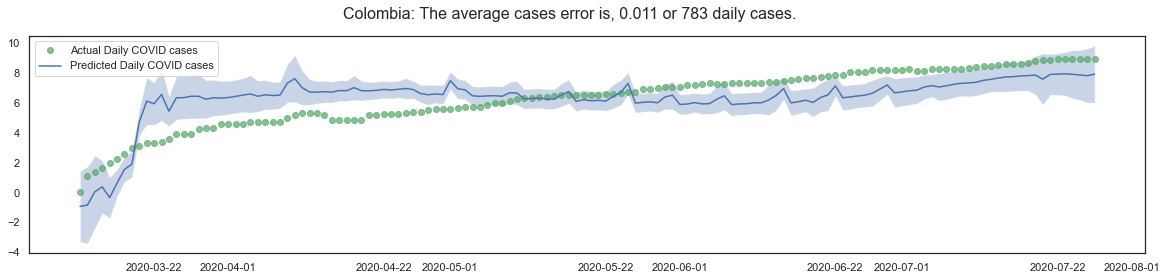

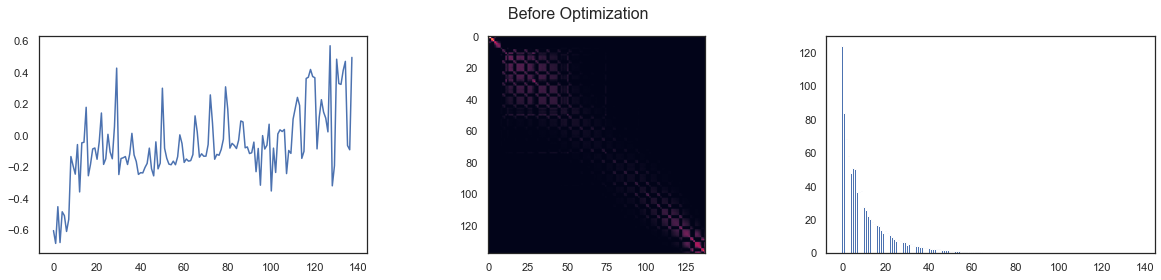

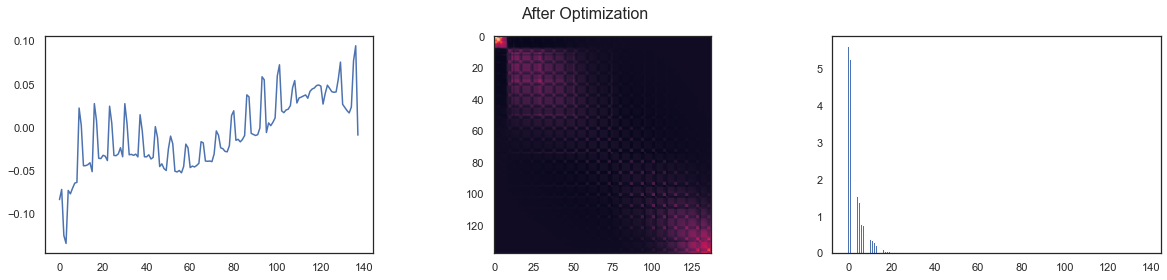

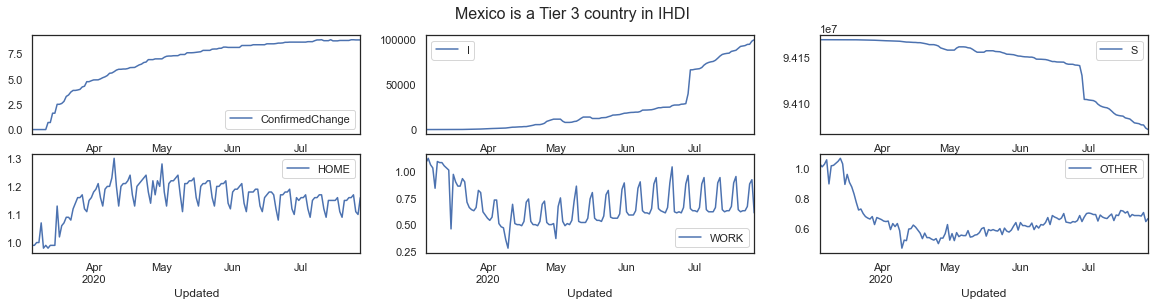

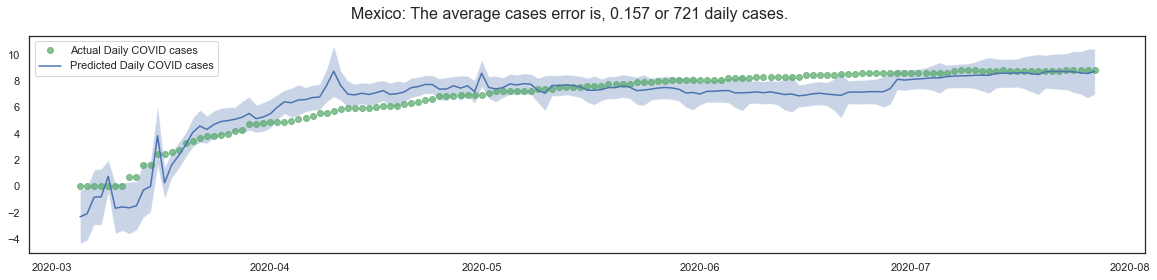

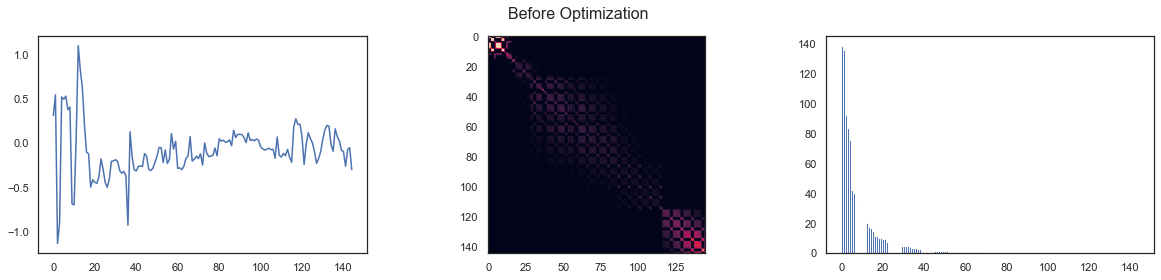

In [ ]:
GP_country_predict(model)